<a href="https://colab.research.google.com/github/AdamPoi/PCVK/blob/main/PCVK_kuis2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!sudo apt-get install tesseract-ocr-ind

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr-ind is already the newest version (1:4.00~git30-7274cfa-1.1).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab import drive
from google.colab.patches import cv2_imshow
import glob
import imutils
import pytesseract

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ktp_images = []
for img in glob.glob('/content/drive/MyDrive/PCVK/Images/ktp_more/*'):
   n = cv2.imread(img)
   n = imutils.resize(n,width=640)
   ktp_images.append(n)

Preprocessing

In [ ]:
thresh_ktp_images=[]
for ktp in ktp_images:
  gray = cv2.cvtColor(ktp,cv2.COLOR_RGB2GRAY)
  blurred = cv2.GaussianBlur(gray,(3,3),0)
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(12, 12))
  clahed = clahe.apply(blurred)
  thresholded = cv2.threshold(clahed,165,255,cv2.THRESH_TRUNC + cv2.THRESH_OTSU)[1]
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
  opened =cv2.morphologyEx(thresholded,cv2.MORPH_OPEN, kernel, iterations=1)
  thresh_ktp_images.append(thresholded)

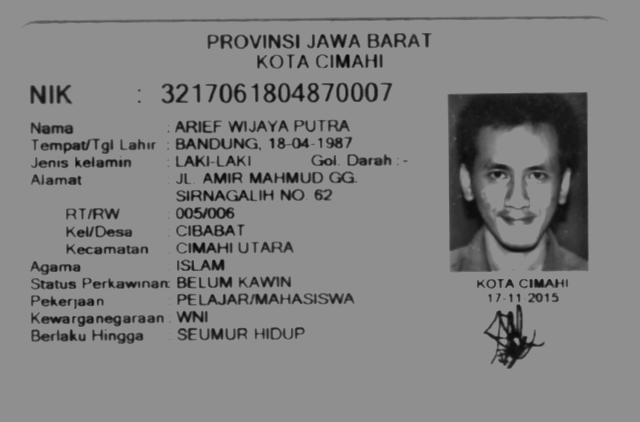

In [ ]:
cv2_imshow(thresh_ktp_images[0])

Deteksi Wajah

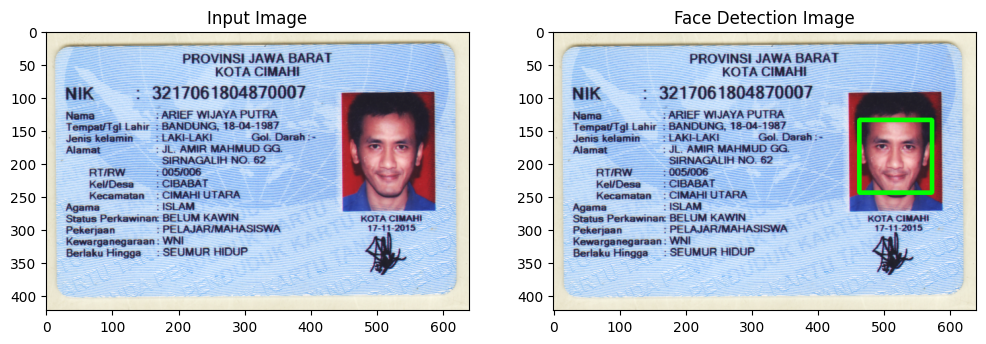

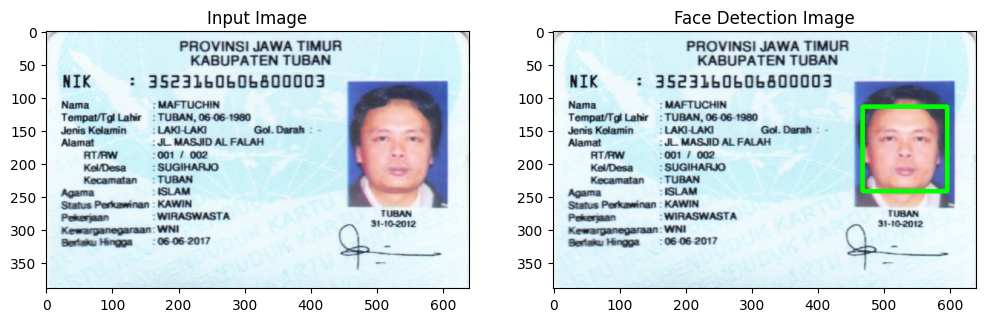

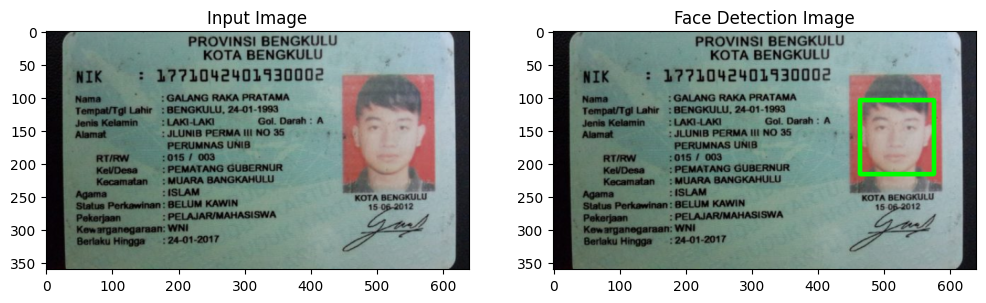

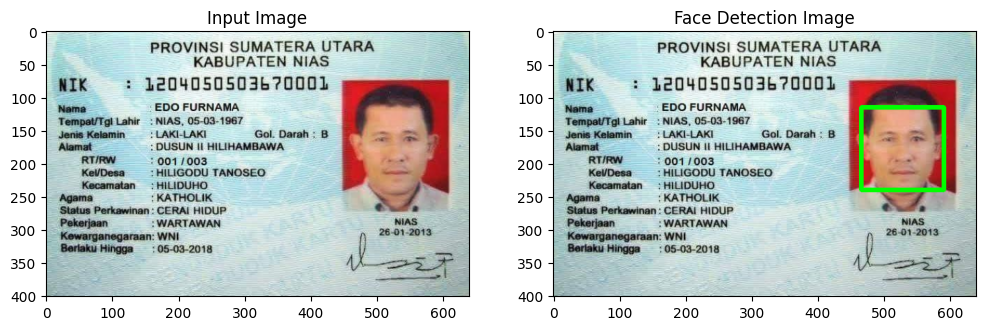

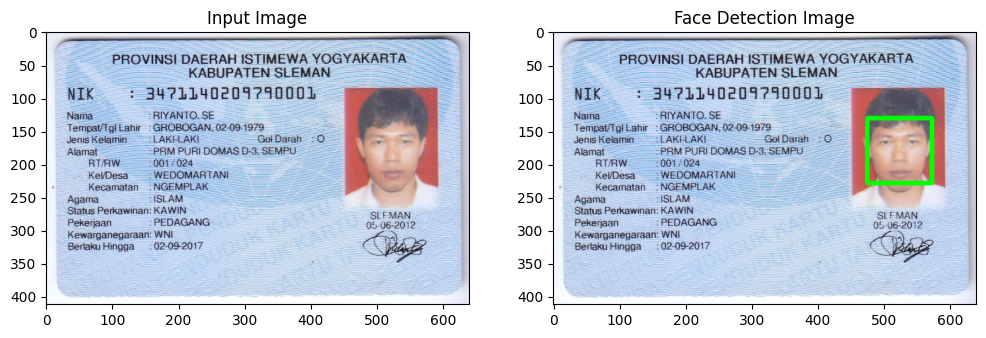

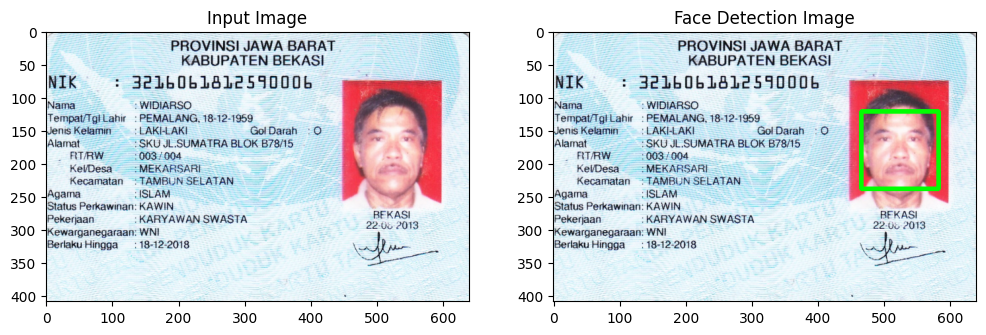

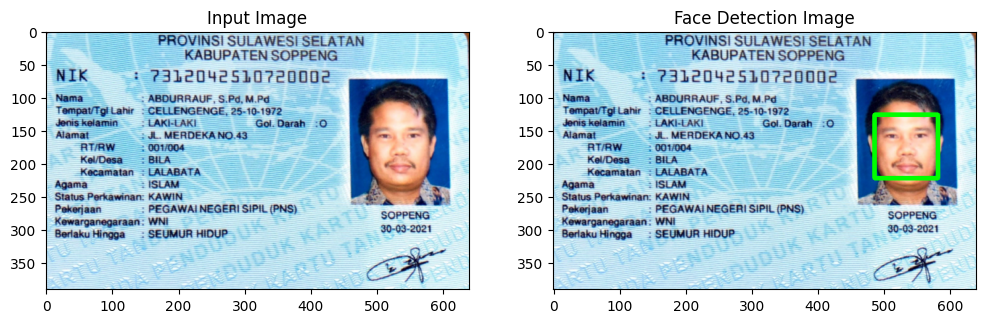

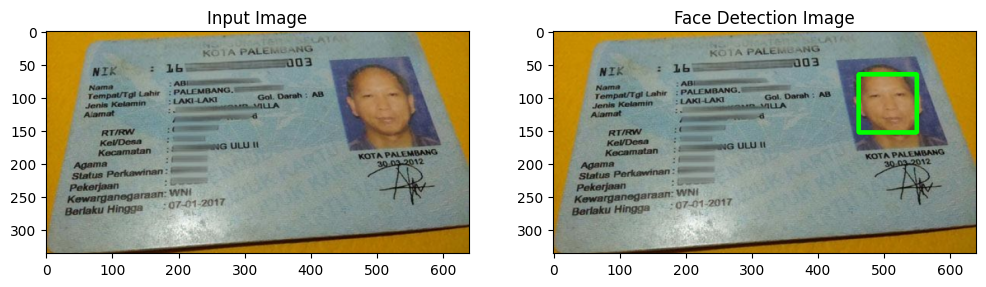

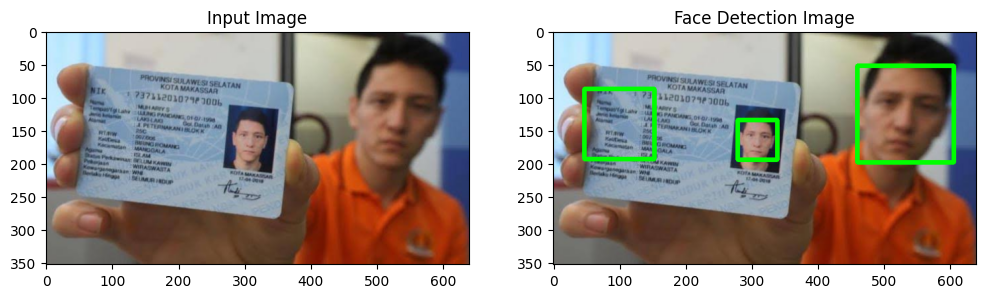

In [ ]:
haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
mn=[5,5,5,2,5,3,5,5,5]
sc = [1.2,1.2,1.2,1.2,1.6,1.1,2,1.2,1.2]
for i,ktp in enumerate(ktp_images):
  facedet_img = ktp.copy()
  faces_rects = haar_cascade.detectMultiScale(ktp, scaleFactor = sc[i], minNeighbors = mn[i]);
  for (x,y,w,h) in faces_rects:
      cv2.rectangle(facedet_img, (x,y),(x+w,y+h),(0,255,0),5)
  plt.figure(figsize=(12, 8))
  plt.subplot(121), plt.imshow(cv2.cvtColor(ktp,cv2.COLOR_BGR2RGB), cmap='gray'), plt.title('Input Image')
  plt.subplot(122), plt.imshow(cv2.cvtColor(facedet_img,cv2.COLOR_BGR2RGB), cmap='gray'), plt.title('Face Detection Image')

In [ ]:

for ktp in thresh_ktp_images:

  result = pytesseract.image_to_string((ktp), lang="ind"  ,config="--psm 1")

In [ ]:

result = pytesseract.image_to_string((thresh_ktp_images[0]), lang="ind"  ,config="--psm 1")
for word in result.split("\n"):
  if "—" in word:
    word = word.replace("—", ":")

  #normalize NIK
  if "NIK" in word:
    nik_char = word.split()
    if "D" in word:
      word = word.replace("D", "0")
    if "?" in word:
      word = word.replace("?", "7")

  print(word)

 

PROVINSI JAWA BARAT

KOTA CIMAHI

NIK : 3217061804870007
Nama ARIEF WIJAYA PUTRA
TempatTgi Lahir : BANDUNG, 18-04-1987

Jenis kelamin LAKI-LAKI Gol. Darah :-
Alamat JL AMIR MAHMUD GG.

SIRNAGALIH NO 62
RTRW 005/006

Kel/Desa CIBABAT
Kecamatan : CIMAHI UTARA

 

Agama ISLAM
Status Perkawinan BELUM KAWIN KOTA CIMAHI
Pekerjaan PELAJAR/MAHASISWA 17-11 2015

Kewarganegaraan. WNI
Berlaku Hingga SEUMUR HIDUP



Transform

In [ ]:
def get_contours(img):
    # First make the image 1-bit and get contours
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, thresh = cv2.threshold(imgray, 0, 255, cv2.THRESH_OTSU)

    contours, hierarchy = cv2.findContours(thresh, 1, 2)

    # filter contours that are too large or small
    size = get_size(img)
    contours = [cc for cc in contours if contourOK(cc, size)]
    return contours

def get_size(img):
    ih, iw = img.shape[:2]
    return iw * ih

def contourOK(cc, size=1000000):
    x, y, w, h = cv2.boundingRect(cc)
    if w < 50 or h < 50: return False # too narrow or wide is bad
    area = cv2.contourArea(cc)
    return area < (size * 0.25) and area > 4000

def find_4_coord(contours):
    for cc in contours:
        x, y, w, h = cv2.boundingRect(cc)

        approx = cv2.approxPolyDP(cc, 0.09 * cv2.arcLength(cc, True), True)
        n = approx.ravel()
        i = 0
        box = []
        for j in n :
            if(i % 2 == 0):
                box.append([n[i], n[i + 1]])
            i = i + 1
    return np.array(box)

def order_points(pts):

    rect = np.zeros((4, 2), dtype = "float32")
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def transform(img, pts):

    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    print(tl, tr, br, bl)

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(img, M, (maxWidth, maxHeight))
    return warped

In [ ]:

def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return rect

def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    # return the warped image
    return warped

[[378   0]
 [479 200]
 [542  72]]


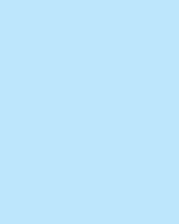

In [ ]:
img=ktp_images[8]
contours = get_contours(img)
pts = find_4_coord(contours)
print(pts)

img_transform = four_point_transform(img, pts)
cv2_imshow(img_transform)

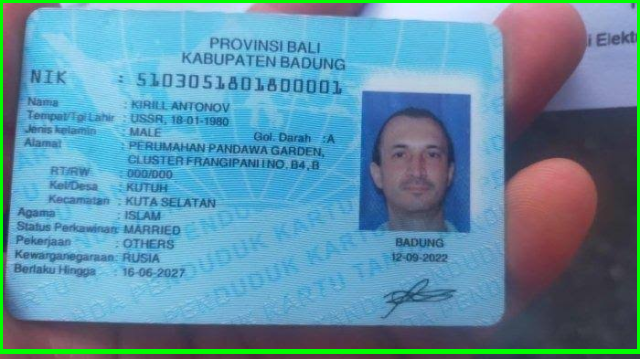

In [ ]:

img=ktp_images[8].copy()
cv2.drawContours(img, contours, -1, (0,255,0), 3)
cv2_imshow(img)

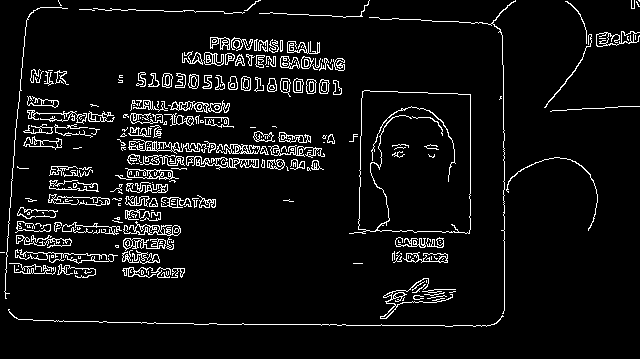

In [160]:
img=ktp_images[8].copy()

edges = cv2.Canny(img, 100, 200)
cv2_imshow(edges)

In [161]:
# Getting contours
contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Finding contour of biggest rectangle
# Otherwise return corners of original image
# Don't forget on our 5px border!
height = edges.shape[0]
width = edges.shape[1]
MAX_COUNTOUR_AREA = (width - 10) * (height - 10)

# Page fill at least half of image, then saving max area found
maxAreaFound = MAX_COUNTOUR_AREA * 0.5

# Saving page contour
pageContour = np.array([[5, 5], [5, height-5], [width-5, height-5], [width-5, 5]])

# Go through all contours
for cnt in contours:
    # Simplify contour
    perimeter = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.03 * perimeter, True)

    # Page has 4 corners and it is convex
    # Page area must be bigger than maxAreaFound
    if (len(approx) == 4 and
            cv2.isContourConvex(approx) and
            maxAreaFound < cv2.contourArea(approx) < MAX_COUNTOUR_AREA):

        maxAreaFound = cv2.contourArea(approx)
        pageContour = approx

# Result in pageConoutr (numpy array of 4 points):

In [162]:
def fourCornersSort(pts):
    """ Sort corners: top-left, bot-left, bot-right, top-right """
    # Difference and sum of x and y value
    # Inspired by http://www.pyimagesearch.com
    diff = np.diff(pts, axis=1)
    summ = pts.sum(axis=1)

    # Top-left point has smallest sum...
    # np.argmin() returns INDEX of min
    return np.array([pts[np.argmin(summ)],
                     pts[np.argmax(diff)],
                     pts[np.argmax(summ)],
                     pts[np.argmin(diff)]])


def contourOffset(cnt, offset):
    """ Offset contour, by 5px border """
    # Matrix addition
    cnt += offset

    # if value < 0 => replace it by 0
    cnt[cnt < 0] = 0
    return cnt


# Sort and offset corners
pageContour = fourCornersSort(pageContour[:, 0])
pageContour = contourOffset(pageContour, (-5, -5))

# Recalculate to original scale - start Points
sPoints = pageContour.dot(image.shape[0] / 800)

# Using Euclidean distance
# Calculate maximum height (maximal length of vertical edges) and width
height = max(np.linalg.norm(sPoints[0] - sPoints[1]),
             np.linalg.norm(sPoints[2] - sPoints[3]))
width = max(np.linalg.norm(sPoints[1] - sPoints[2]),
             np.linalg.norm(sPoints[3] - sPoints[0]))

# Create target points
tPoints = np.array([[0, 0],
                    [0, height],
                    [width, height],
                    [width, 0]], np.float32)

# getPerspectiveTransform() needs float32
if sPoints.dtype != np.float32:
    sPoints = sPoints.astype(np.float32)

# Wraping perspective
M = cv2.getPerspectiveTransform(sPoints, tPoints)
newImage = cv2.warpPerspective(image, M, (int(width), int(height)))

# Saving the result. Yay! (don't forget to convert colors bact to BGR)
cv2_imshow(newImage)

AxisError: ignored